# Libraries

In [1]:
# basic libraries
import pandas as pd
import os
import sys
import numpy as np
from datetime import timedelta
import warnings

# visualisation libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
import seaborn as sns

# statistical libraries
from scipy.stats.contingency import association
from scipy.stats import chi2_contingency

# admin
sys.path.append(os.path.abspath(".."))
from utils import helper_functions as hf

# settings
# pd.set_option('display.max_row', None) # display all rows
pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings

# colors
color1='black'
color2='forestgreen'
color3='mediumblue'

# Opening the data

In [2]:
filepath = '../data/events_cleaned.csv' 
df = pd.read_csv(filepath) 
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,last_view_before_purchase,last_view_before_cart,already_in_cart
0,2020-10-29 11:28:35+00:00,view,4101974,2144415939364389423,electronics.clocks,honor,76.48,1515915625353226922,0,0,0
1,2020-10-06 06:30:32+00:00,view,3506650,2144415935673401802,Unknown,kester,28.98,1515915625353230067,0,0,0
2,2020-11-09 08:52:51+00:00,view,124883,2144415924424278172,electronics.audio.acoustic,logitech,23.90,1515915625353230683,0,0,0
3,2020-11-09 09:08:53+00:00,view,125325,2144415924424278172,electronics.audio.acoustic,logitech,23.90,1515915625353230683,0,0,0
4,2020-11-18 10:51:35+00:00,view,254763,2144415924424278172,electronics.audio.acoustic,creative,74.24,1515915625353230683,0,0,0


# Explorative data analysis

## Event Type Count Imbalance

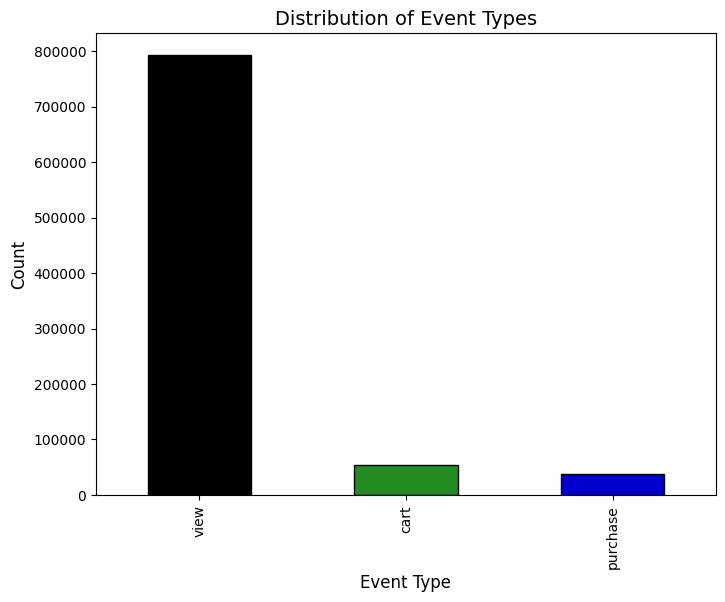

In [3]:
# Count the occurrences of each unique event_type
event_type_counts = df['event_type'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
event_type_counts.plot(kind='bar', color=[color1, color2, color3], edgecolor='black')

# Add labels and title
plt.xlabel('Event Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Event Types', fontsize=14)

# Save and show the plot
plt.savefig("../images/event_type_distribution.png")
plt.show()

# Time Manipulations

In [4]:
# convert the 'event_time' column to datetime format
df['event_time'] = pd.to_datetime(df['event_time'])
# extract the full hour from the event_time column and create a new column time_of_day
df['time_of_day'] = df['event_time'].dt.strftime('%H:00:00')
# creating a day of week column
df['day_of_week'] = df['event_time'].dt.day_name()
# creating a month column in order to check distribution of events per month
df['month'] = df['event_time'].dt.to_period('M').astype(str)
# checking the timeframe period of the dataframe
print(f"The dataframe time spans from {df.event_time.min()} and ends with {df.event_time.max()}")

The dataframe time spans from 2020-09-24 11:57:06+00:00 and ends with 2021-02-28 23:59:09+00:00


In [5]:
# the number of events per month and event type
df.groupby(['month', 'event_type']).size()

month    event_type
2020-09  cart            1412
         purchase        1007
         view           25640
2020-10  cart            8728
         purchase        6276
         view          146414
2020-11  cart           10435
         purchase        7574
         view          170082
2020-12  cart            9342
         purchase        6529
         view          136719
2021-01  cart           12695
         purchase        8315
         view          166431
2021-02  cart           11420
         purchase        7642
         view          147813
dtype: int64

### Timeseries of Event Type

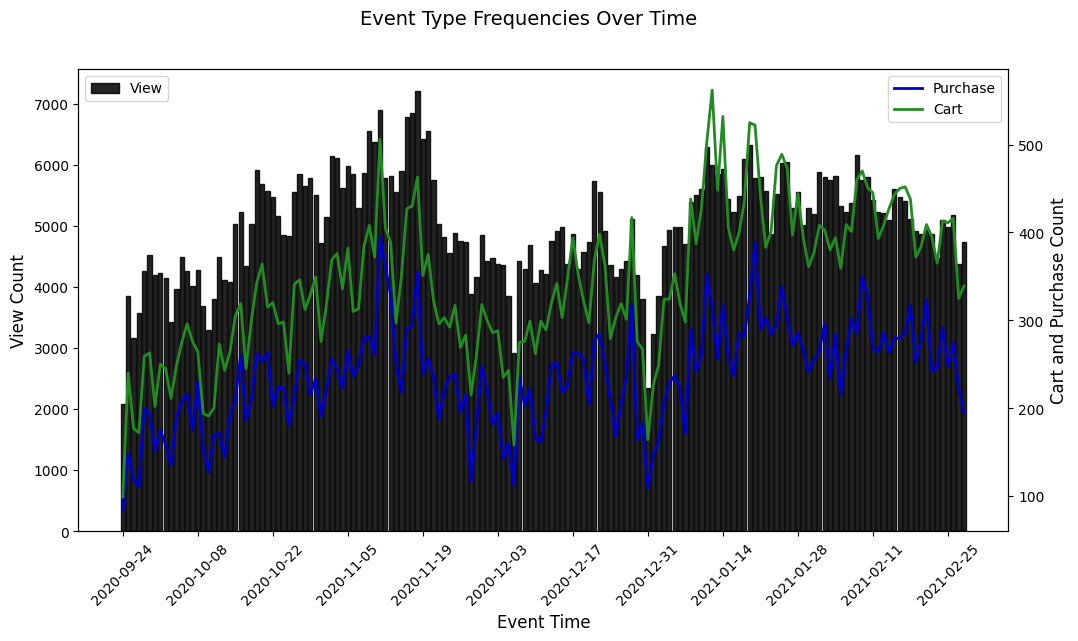

In [6]:
# set event_time as the index
df.set_index('event_time', inplace=True)

# count the number of events per day
view_counts = df[df['event_type'] == 'view'].resample('D').size()
cart_counts = df[df['event_type'] == 'cart'].resample('D').size()
purchase_counts = df[df['event_type'] == 'purchase'].resample('D').size()

xticks = pd.date_range(start=view_counts.index.min(), end=view_counts.index.max(), freq='14D')
xtick_label = [date.strftime('%Y-%m-%d') for date in xticks]

hf.plot_dual_axis_bar_line(xticks, xtick_label, view_counts, purchase_counts, cart_counts, 'Event Time', "View Count", 'Cart and Purchase Count', 'Event Type Frequencies Over Time')

df.reset_index(inplace=True)

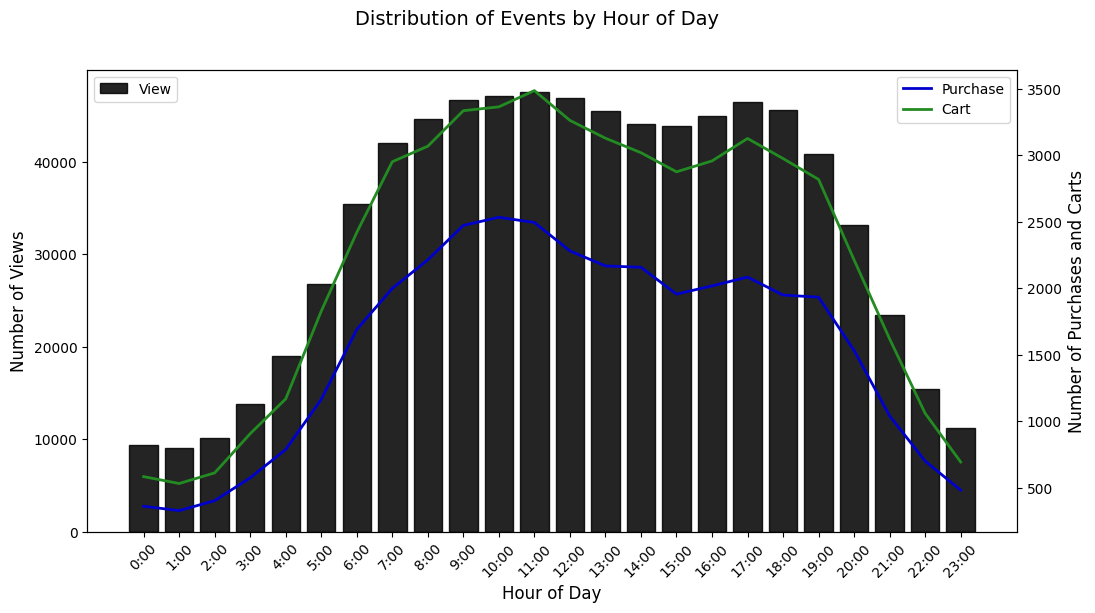

In [7]:
# create what needs to be plotted
view_time_of_day = df[df['event_type'] == 'view']['time_of_day'].value_counts().sort_index()
purchase_time_of_day = df[df['event_type'] == 'purchase']['time_of_day'].value_counts().sort_index()
cart_time_of_day = df[df['event_type'] == 'cart']['time_of_day'].value_counts().sort_index()


hf.plot_dual_axis_bar_line((range(0, 24)), [f"{h}:00" for h in range(24)], view_time_of_day, purchase_time_of_day, cart_time_of_day, 'Hour of Day', 'Number of Views', 'Number of Purchases and Carts', 'Distribution of Events by Hour of Day')

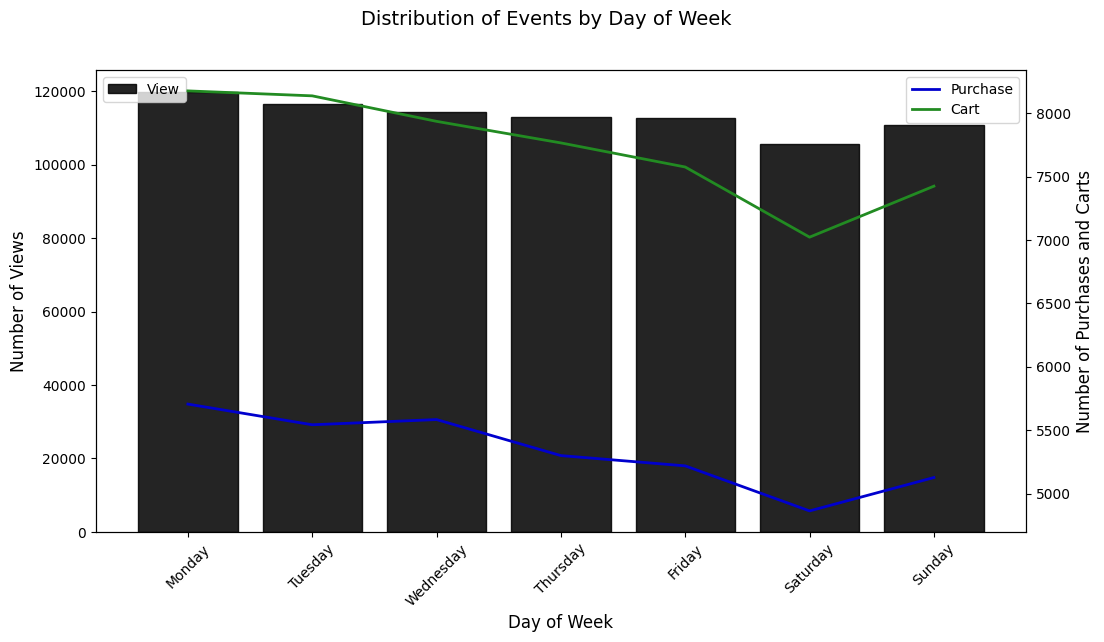

In [8]:
# the natural order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# define what needs to be plotted
view_day_of_week = df[df['event_type'] == 'view']['day_of_week'].value_counts().reindex(day_order)
purchase_day_of_week = df[df['event_type'] == 'purchase']['day_of_week'].value_counts().reindex(day_order)
cart_day_of_week = df[df['event_type'] == 'cart']['day_of_week'].value_counts().reindex(day_order)

hf.plot_dual_axis_bar_line((range(len(view_day_of_week.index))), view_day_of_week.index, view_day_of_week, purchase_day_of_week, cart_day_of_week, 'Day of Week', 'Number of Views', 'Number of Purchases and Carts', 'Distribution of Events by Day of Week')

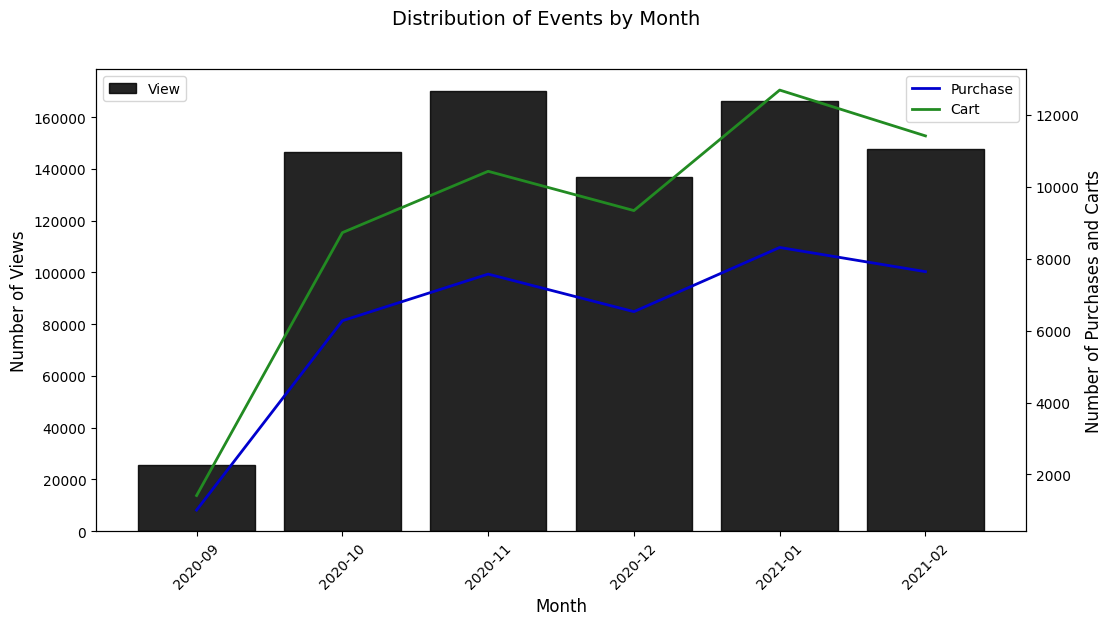

In [9]:
# create what needs to be plotted
view_month = df[df['event_type'] == 'view']['month'].value_counts().sort_index()
purchase_month = df[df['event_type'] == 'purchase']['month'].value_counts().sort_index()
cart_month = df[df['event_type'] == 'cart']['month'].value_counts().sort_index()

xticks = range(len(view_month.index))
xtick_label = view_month.index.astype(str)

hf.plot_dual_axis_bar_line(xticks, xtick_label, view_month, purchase_month, cart_month, 'Month', 'Number of Views', 'Number of Purchases and Carts', 'Distribution of Events by Month')


# Creating two groups:
- non_purchase_views (views that do not lead to a purchase)
- purchase_views (views that lead to a purchase)

In [10]:
# filter the DataFrame to include only 'view' events
view_df = df[df['event_type'] == 'view']
non_purchase_views = view_df[view_df["last_view_before_purchase"] == 0]
purchase_views = view_df[view_df["last_view_before_purchase"] == 1]

# Purchasers vs. Non-Purchaser Views

Plotting the price distribution and outlier format for views that do not lead to a purchase

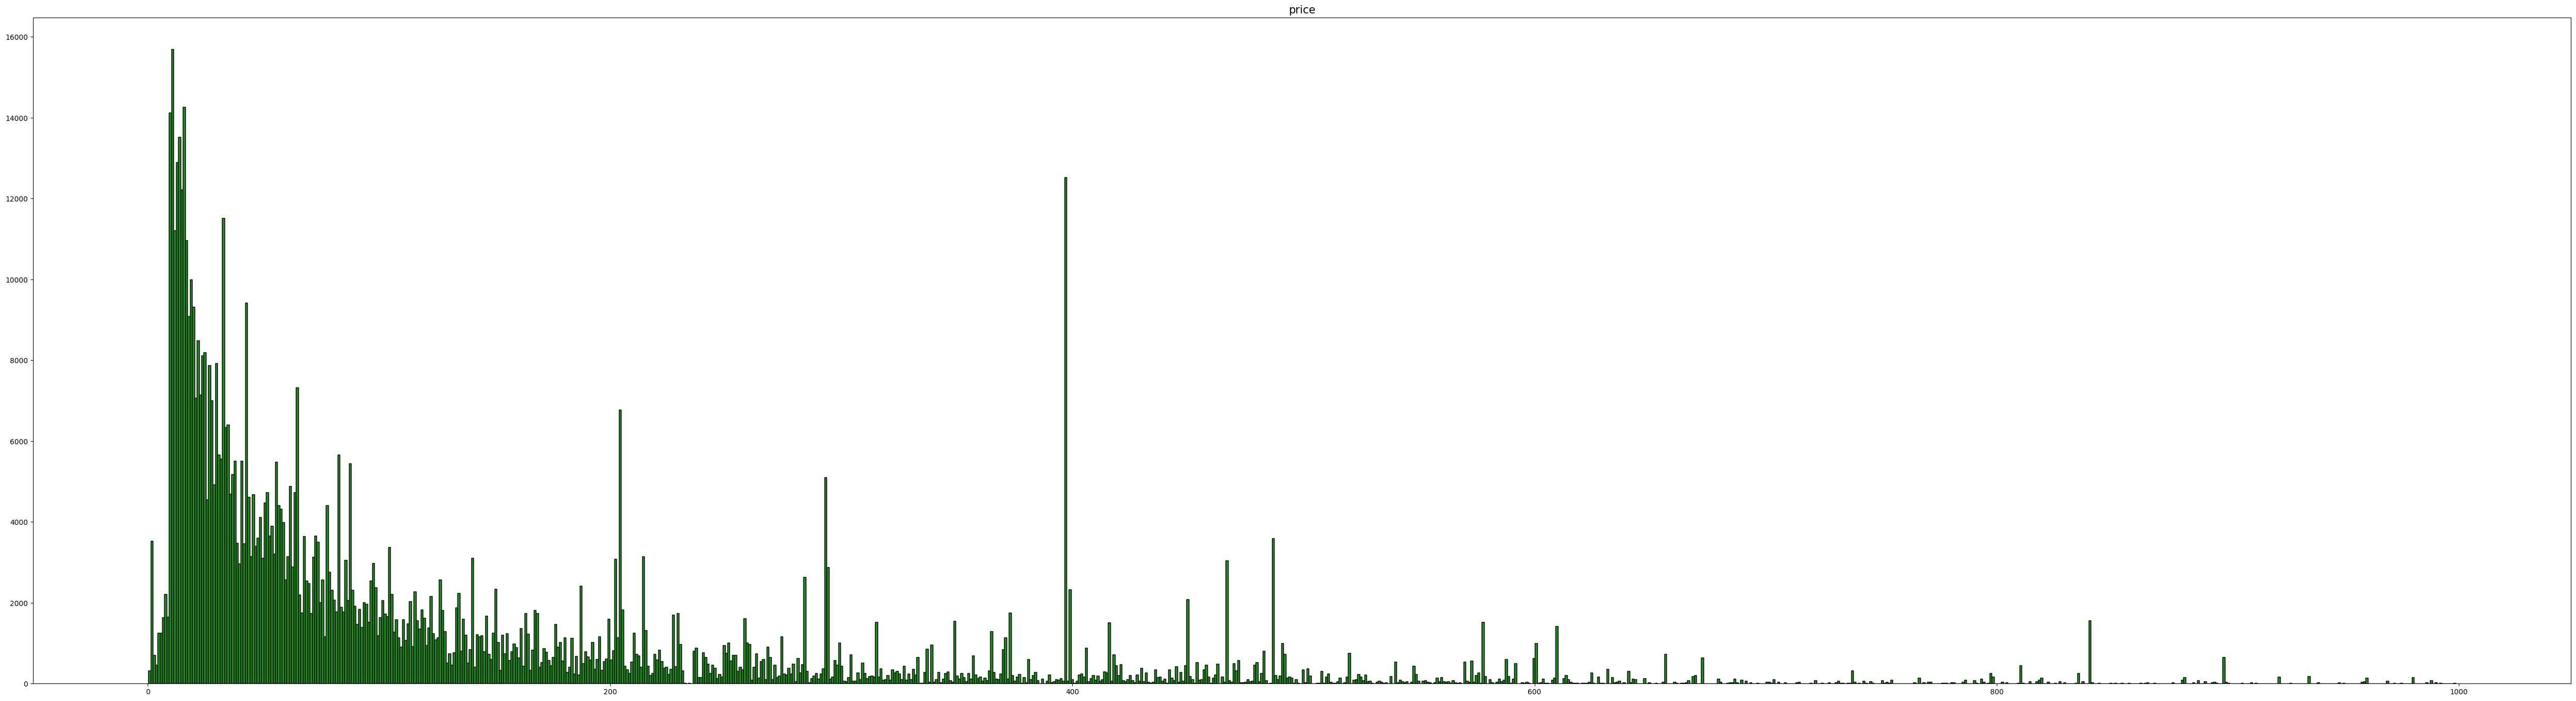

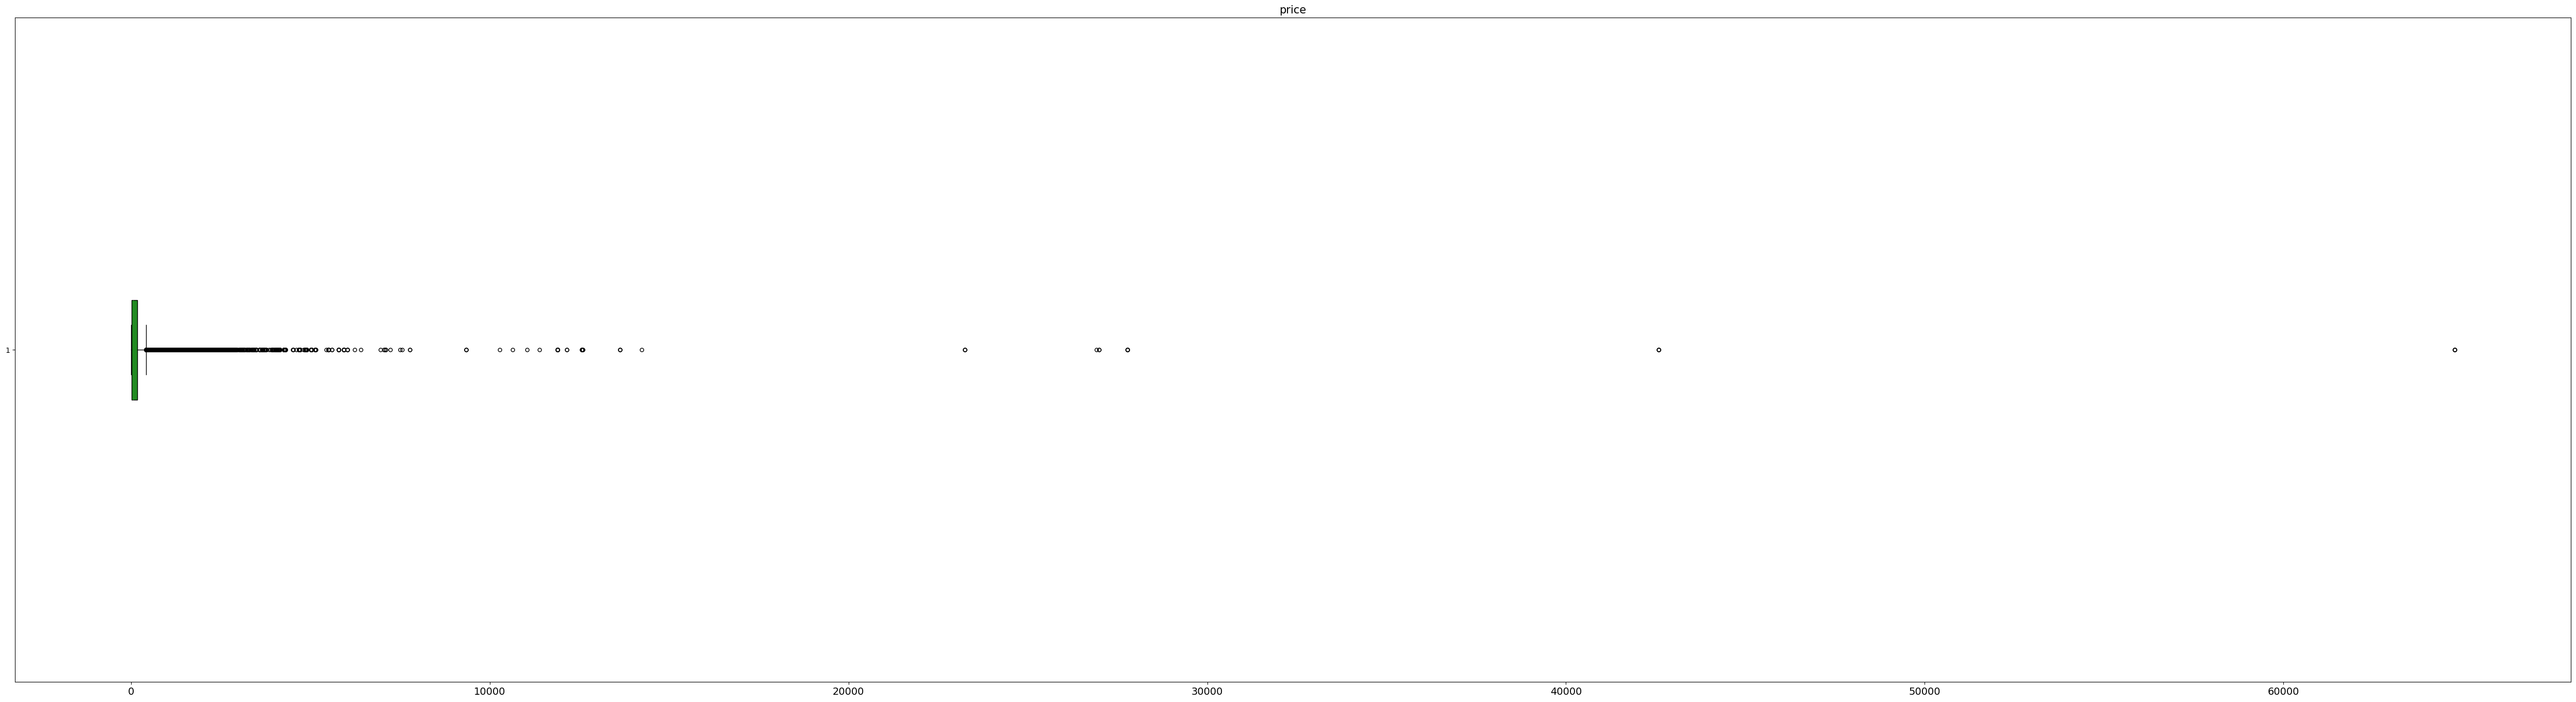

In [11]:
hf.create_distribution_plot(hf.create_subset(non_purchase_views, ['price']), 'distribution', 1000)
hf.create_distribution_plot(hf.create_subset(non_purchase_views, ['price']), 'outliers')

Plotting the price distribution and outliers for views that do lead to a purchase

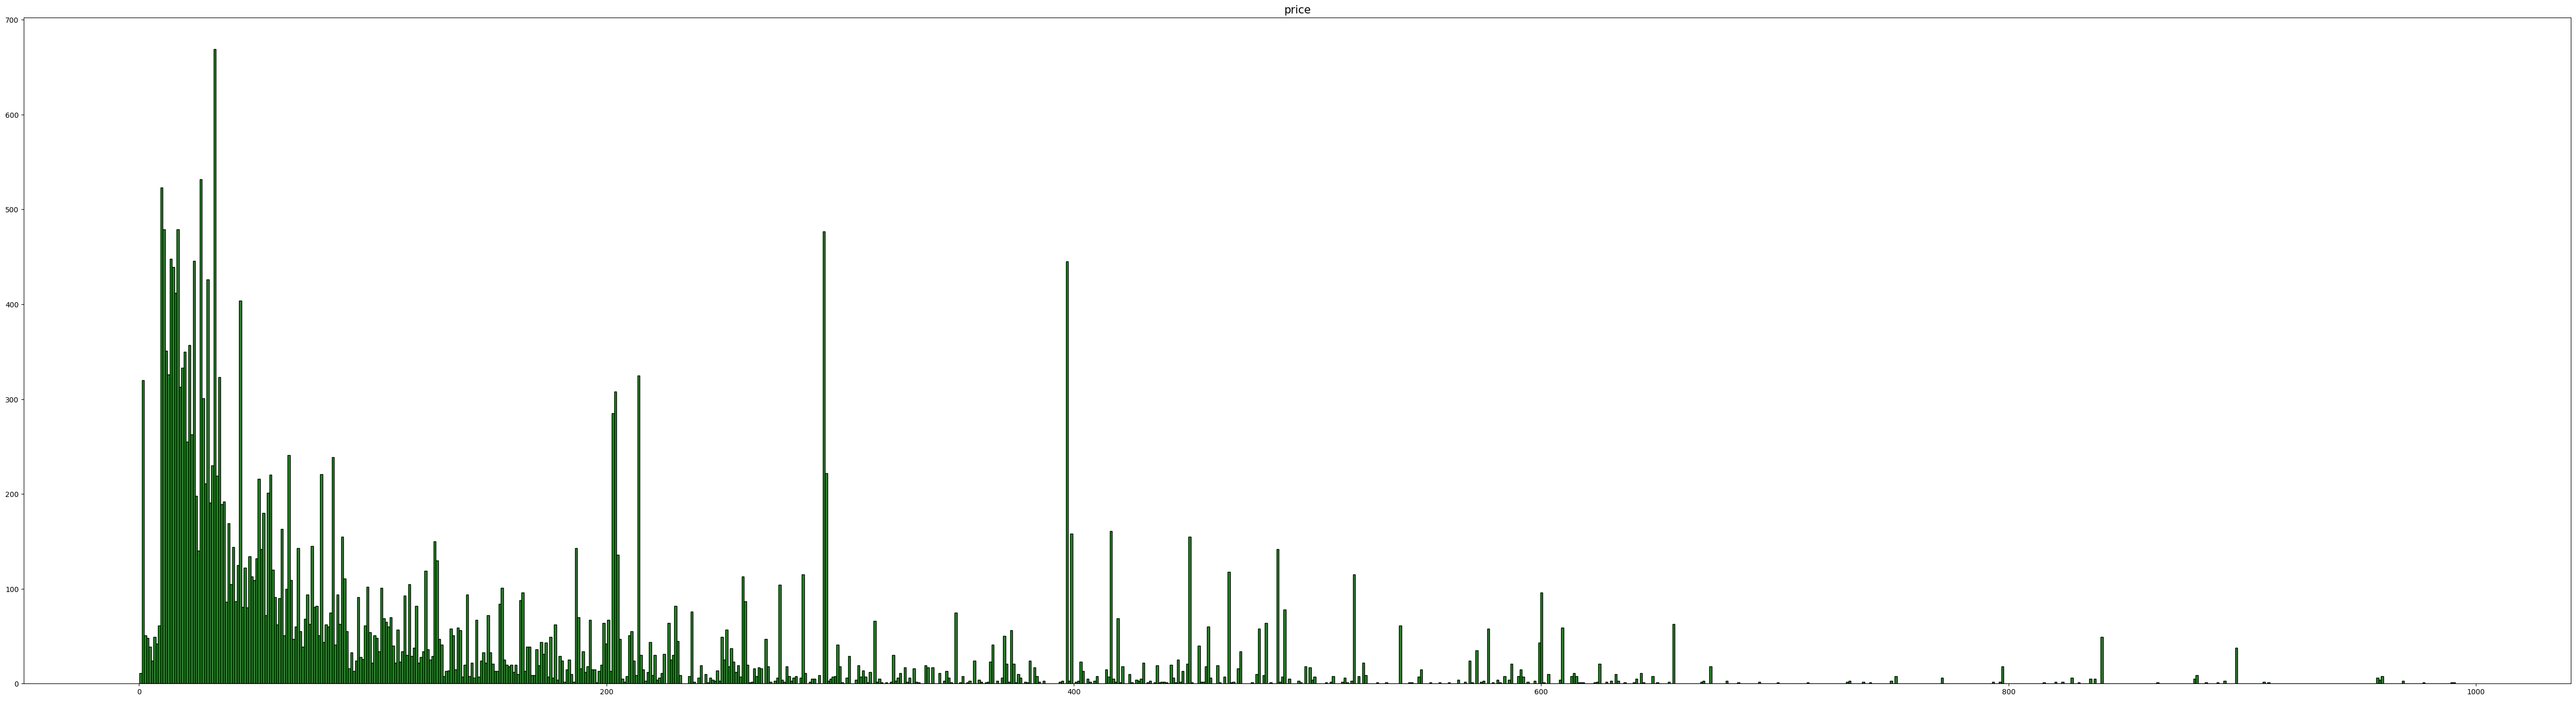

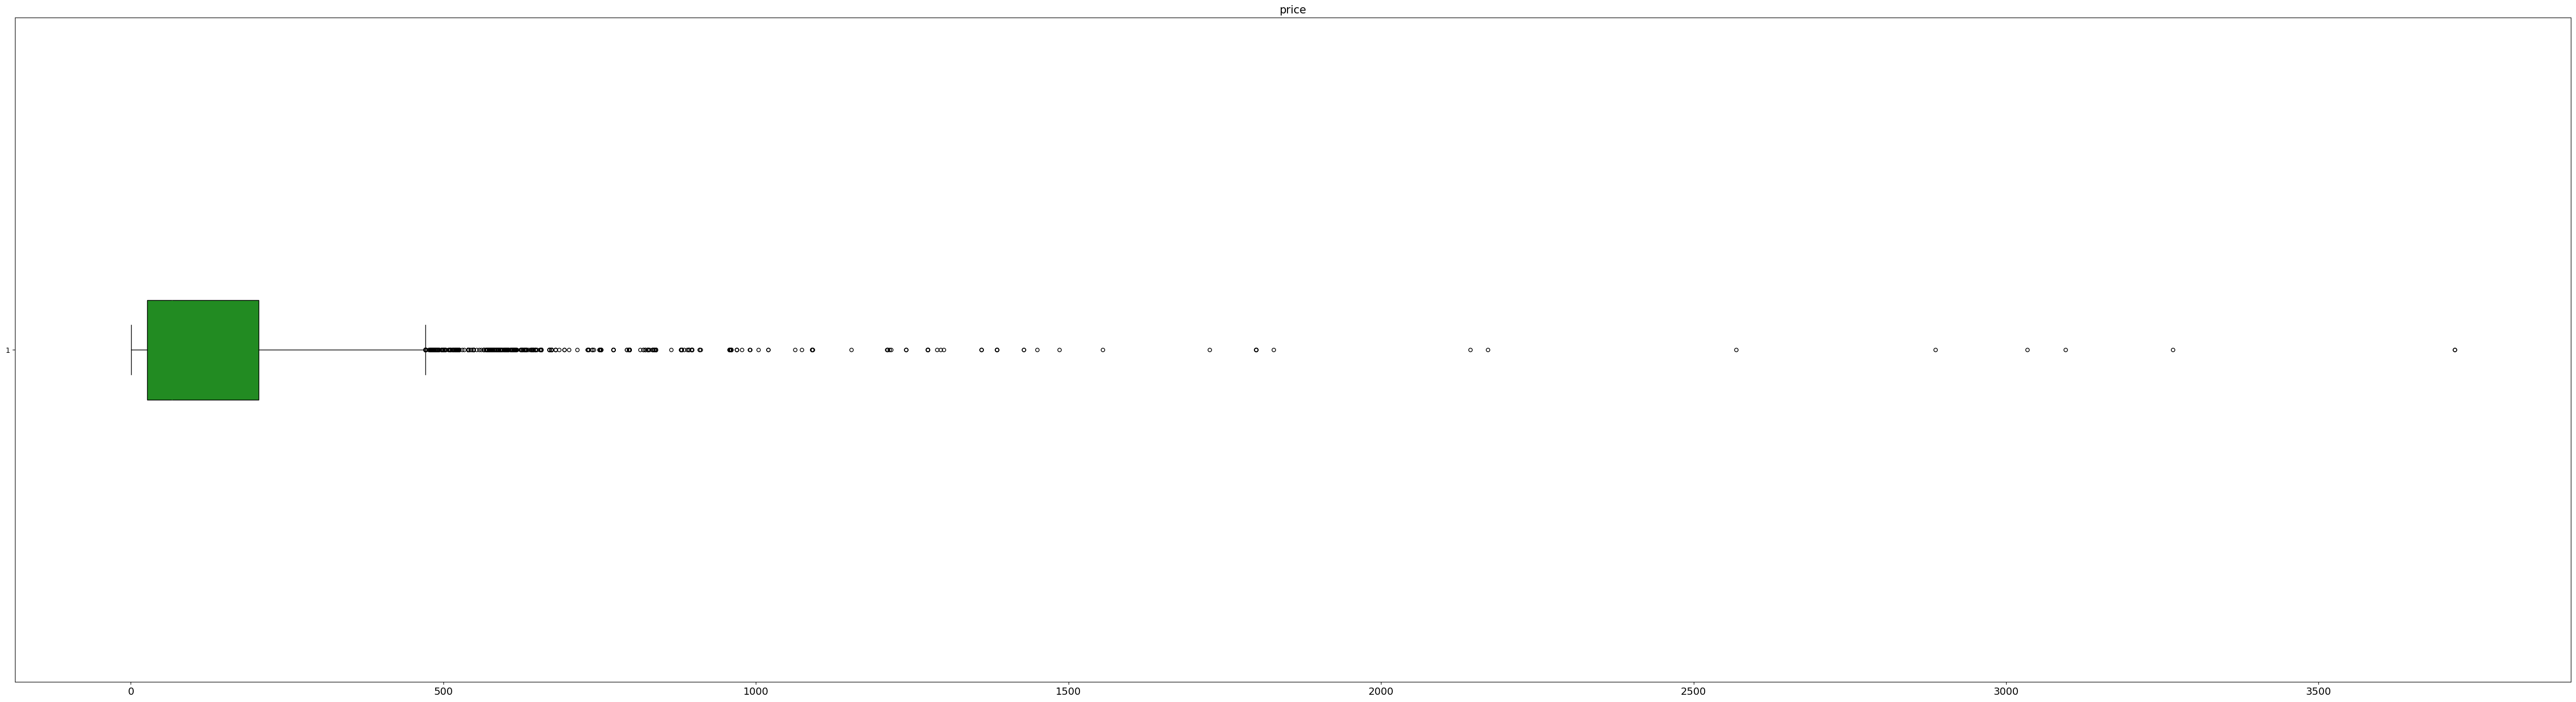

In [12]:
hf.create_distribution_plot(hf.create_subset(purchase_views, ['price']), 'distribution')
hf.create_distribution_plot(hf.create_subset(purchase_views, ['price']), 'outliers')

### Discretizing the price
According the price span for our target and non-target class decided to discretize the price up until 3000 which seems to be the span users purchase for.

In [13]:
# Define price bins and labels
price_bins = [0, 10, 50, 100, 200, 500, 1000, 2000, 3000, float('inf')]
price_labels = ['0-10', '10-50','50-100', '100-200', '200-500', '500-1000', '1000-2000', '2000-3000', '3000+']

# Create a new column for discretized price
df['price_range'] = pd.cut(df['price'], bins=price_bins, labels=price_labels, right=False)

# Display the first few rows to verify
df[['price', 'price_range']].head()

,price,price_range
0,76.48,50-100
1,28.98,10-50
2,23.90,10-50
3,23.90,10-50
4,74.24,50-100


# Adding Time since last View (discretized)

In [14]:
# sort the DataFrame by user_id, product_id, and event_time
df = df.sort_values(by=['user_id', 'product_id', 'event_time'])

# calculate the time difference between consecutive rows within each group
df['time_since_last_view'] = df.groupby(['user_id', 'product_id'])['event_time'].diff()

# define bins and labels for discretization
bins = [0, 5, 30, 60, 180, 360, 720, float('inf')]  # Bins in minutes
labels = ['<5 min', '5-30 min', '30-60 min', '1-3 hrs', '3-6 hrs', '6-12 hrs', '>12 hrs']

# discretize the time_since_last_view column
df['time_since_last_view_binned'] = pd.cut(
    df['time_since_last_view'].dt.total_seconds() / 60,  # Convert to minutes
    bins=bins,
    labels=labels,
    right=False
)
pd.set_option('display.max_row', None) # display all rows
user_data = df[df['user_id'] == 1515915625556087775]
hf.create_subset(user_data, ['event_time', 'user_id', 'product_id', 'time_since_last_view', 'time_since_last_view_binned']).sort_values(by=['product_id', 'event_time']).head(20)

,event_time,user_id,product_id,time_since_last_view,time_since_last_view_binned
447842,2020-12-12 04:03:53+00:00,1515915625556087775,564615,NaT,NaN
447843,2020-12-10 01:37:03+00:00,1515915625556087775,564619,NaT,NaN
447844,2021-01-01 13:49:16+00:00,1515915625556087775,564620,NaT,NaN
447845,2021-01-01 23:33:20+00:00,1515915625556087775,564620,0 days 09:44:04,6-12 hrs
447846,2021-01-02 04:26:35+00:00,1515915625556087775,564620,0 days 04:53:15,3-6 hrs
447847,2020-12-09 06:56:17+00:00,1515915625556087775,564686,NaT,NaN
447848,2020-12-09 23:59:25+00:00,1515915625556087775,564686,0 days 17:03:08,>12 hrs
447849,2020-12-10 02:16:20+00:00,1515915625556087775,622456,NaT,NaN
447850,2020-12-09 07:47:49+00:00,1515915625556087775,651563,NaT,NaN
447851,2020-12-21 13:56:21+00:00,1515915625556087775,651563,12 days 06:08:32,>12 hrs


# Grouping Product ID

In [15]:
view_df.product_id.nunique() #number of unique products

53452

### Confirming that product_id, category_id and category_code are inherently grouped

In [16]:
contingency_table = pd.crosstab(df['product_id'], df['category_id'])
cramers_v = association(contingency_table, method='cramer')
print(f"Cramér's V: {cramers_v:.2f}")

Cramér's V: 1.00


In [17]:
contingency_table = pd.crosstab(df['category_code'], df['category_id'])
cramers_v = association(contingency_table, method='cramer')
print(f"Cramér's V: {cramers_v:.2f}")

Cramér's V: 1.00


### Splitting category code into three parts

In [18]:
# split category_code into three parts
df[['code1', 'code2', 'code3']] = df['category_code'].str.split('.', n=2, expand=True)

# fill missing parts with "unknown"
df['code1'] = df['code1'].fillna('unknown')
df['code2'] = df['code2'].fillna('unknown')
df['code3'] = df['code3'].fillna('unknown')

# look at some new columns
print(df[['category_code', 'code1', 'code2', 'code3']].head())

                category_code        code1    code2     code3
0          electronics.clocks  electronics   clocks   unknown
1                     Unknown      Unknown  unknown   unknown
2  electronics.audio.acoustic  electronics    audio  acoustic
3  electronics.audio.acoustic  electronics    audio  acoustic
4  electronics.audio.acoustic  electronics    audio  acoustic


As there are so many unique products, we should try to reduce the amount and put the long tail into "other" product. Trying to plot it would help with deciding where to make the cut

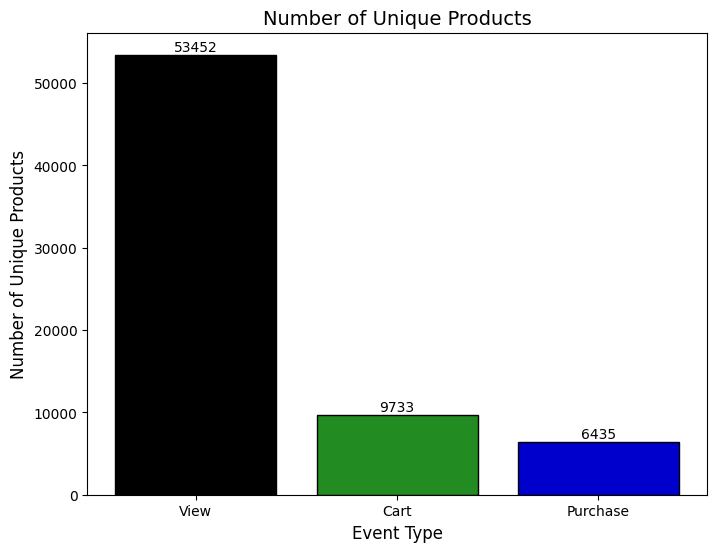

In [19]:
unique_products = {
    'View': df[df['event_type'] == 'view'].product_id.nunique(),
    'Cart': df[df['event_type'] == 'cart'].product_id.nunique(),
    'Purchase': df[df['event_type'] == 'purchase'].product_id.nunique()
    
   
}

# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(unique_products.keys(), unique_products.values(), color=[color1, color2, color3], edgecolor=color1)

# Add labels and title
ax.set_ylabel('Number of Unique Products', fontsize=12)
ax.set_xlabel('Event Type', fontsize=12)
ax.set_title('Number of Unique Products', fontsize=14)
ax.bar_label(ax.containers[0], label_type='edge', fontsize=10)

# Save and show the plot
plt.savefig("../images/unique_products_by_event_type.png")
plt.show()

After seeing this graph I decided to make the cut at 20 000 products. All products with purchase or cart event should be included plus then whatever product has the highest view counts

In [20]:
# get all products with specific event types
cart_product_ids = df[df['event_type'] == 'cart']['product_id'].unique()
purchase_product_ids = df[df['event_type'] == 'purchase']['product_id'].unique()

# get the most viewed products
top_viewed_product_ids = (
    df[df['event_type'] == 'view']
    .product_id.value_counts()
    .index
)

# combine all product ids series to get the top 10k
top_20k_product_ids = (
    pd.concat([pd.Series(cart_product_ids), pd.Series(purchase_product_ids), pd.Series(top_viewed_product_ids)])
    .drop_duplicates()
    .head(20000)
    .tolist()
)

len(top_20k_product_ids)

20000

Re-naming all non top 20k products as "other"

In [21]:
# rename product_ids not in top_10k_product_ids to "other"
df['product_id'] = df['product_id'].apply(lambda x: x if x in top_20k_product_ids else 'other')
# number of unique product_ids
df['product_id'].nunique()

20001

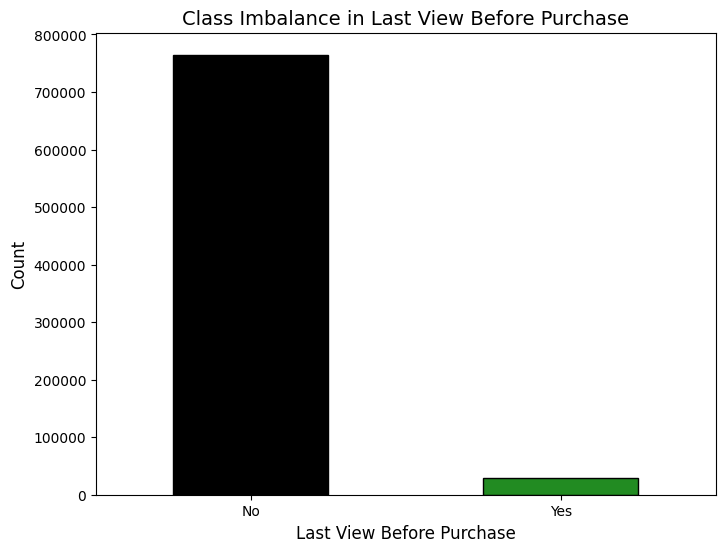

In [22]:
# count the occurrences of each class in the 'last_view_before_purchase' column
class_counts = view_df['last_view_before_purchase'].value_counts()

# barplot
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=[color1, color2], edgecolor='black')

# labels and title
plt.xlabel('Last View Before Purchase', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Imbalance in Last View Before Purchase', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)

# save and show the plot
plt.savefig("../images/class_imbalance_last_view_before_purchase.png")
plt.show()

In [23]:
# create a new df for ML
view_df = df[df['event_type'] == 'view'] # we need to re-do this for the newly added columns
# dropping category code, event_time, event_type and user_id
ml = hf.create_subset(view_df, ['product_id', 'category_id',
       'brand', 'last_view_before_cart', 'already_in_cart',
       'time_of_day', 'day_of_week', 'month', 'price_range', 'code1', 'code2',
       'code3', 'time_since_last_view_binned', 
       'last_view_before_purchase'])
#check for duplicates which are bound to be without event_time and user_id
ml.duplicated().sum()

108016

In [24]:
# ml = ml.drop_duplicates().reset_index(drop=True) #not sure what is the best practice here, but I would leave them as they are real.
ml.to_csv('../data/events_ml.csv', index=False)

In [25]:
df.category_code.nunique() # number of unique category codes

108

In [ ]:
df.brand.nunique()  # number of unique brands

1000

In [ ]:
df.category_id.nunique() # number of unique category ids

718

In [28]:
df.price.max(), df.price.min() # max and min price

(64771.06, 0.22)